In [1]:
import numpy as np
import pandas as pd
import os
import sys

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.timeseries import LombScargle

# import tkinter
import matplotlib
# %matplotlib inline
# matplotlib.use('TkAgg')
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

import seaborn as sns
sns.set(style="darkgrid")

from scipy.stats import gaussian_kde


In [2]:
data_dir = './data/'
object = 'J1503.7-5801'
ebin_number = 4

filename_events = data_dir+object+'/'+'events_4FGL_'+object+'_e'+str(ebin_number)+'.txt'
filename_out7   = data_dir+object+'/'+'4FGL_'+object+'_out7_rois.txt'
filename_out10  = data_dir+object+'/'+'out10_lc_e'+str(ebin_number)+'.txt'


In [3]:
'''
out10 file
day binning
'''

out10 = np.loadtxt(filename_out10)
print('out10 fileshape: '+str(out10.shape))

time_bin_start = out10[:,0]
time_bin_end   = time_bin_start + out10[:,1]

counts_bin     = out10[:,2]
exposure_bin   = out10[:,4]

total_counts_out10 = np.sum(counts_bin)
print('Total counts from out10: '+str(int(total_counts_out10)))

## sampling array
sample_rate = 5
sample_offset = 0
time_bin_start_samp = time_bin_start[sample_offset:-sample_rate:sample_rate]
time_bin_end_samp = time_bin_end[sample_offset+sample_rate-1::sample_rate]
num_samp_bins = len(time_bin_start_samp)

time_bin_samp_mets = (time_bin_start_samp + time_bin_end_samp)/2
time_bin_samp_days = time_bin_samp_mets/(60*60*24) + 2451910.5
time_bin_samp_days-= time_bin_samp_days.min()
# print(time_bin_start_samp[:5])
# print(time_bin_end_samp[:5])

counts_bin_samp = np.zeros(num_samp_bins)
exposure_bin_samp = np.zeros(num_samp_bins)
for ii in range(0,num_samp_bins):
    samp_arr = np.logical_and(time_bin_start>=time_bin_start_samp[ii], time_bin_end<=time_bin_end_samp[ii])
    counts_bin_samp[ii] = np.sum(counts_bin[samp_arr])
    exposure_bin_samp[ii] = np.sum(exposure_bin[samp_arr])
print('Number condensed bins: '+str(len(time_bin_start_samp)))

## renormalize exposure to counts
counts_bin_samp_avg = np.mean(counts_bin_samp[ii])
exposure_bin_samp_avg = np.mean(exposure_bin_samp)

# exposure_bin_samp*= counts_bin_samp_avg/exposure_bin_samp_avg

# print(counts_bin_samp[:5])
# print(exposure_bin_samp[:5])

out10 fileshape: (4047, 5)
Total counts from out10: 4023
Number condensed bins: 809


In [4]:
'''
out7 file
'''

out7 = np.loadtxt(filename_out7)
print('out7 fileshape: '+str(out7.shape))

bin_energy = out7[ebin_number,1]
bin_roi    = out7[ebin_number,2]
print('Bin Energy: '+str(bin_energy))
print('Bin ROI: '+str(bin_roi))

out7 fileshape: (20, 8)
Bin Energy: 794.328234724
Bin ROI: 0.46


In [5]:
'''
EVENTS FILE
0 - Arrival time (METS)
1 - energy (MeV)
2 - RA
3 - DEC
4 - Long
5 - Lat
6 - Theta (instrumental)
7 - SkyCoordinate (instrumental)
8 - Zenith angle (earth)
9 - Earth azimuth (Earth)
'''

read_in = np.loadtxt(filename_events)

time_mets = read_in[:,0]
total_events = len(time_mets)

## time in days
time = read_in[:,0]/(60*60*24) + 2451910.5
time-= np.amin(time)

energy = read_in[:,1]

In [6]:
print('Data shape: '+str(read_in.shape))
print('First Event: '+str(read_in[0]))

Data shape: (4023, 10)
First Event: [ 2.39622731e+08  9.04852000e+02  2.26233000e+02 -5.78051000e+01
  3.19977000e+02  5.79792000e-01  6.21862000e+00  3.41014000e+02
  3.29033000e+01  1.87229000e+02]


In [7]:
RA_obj = 15 *u.hour + 3.7 *u.min
DE_obj = -58.01 *u.deg

c_obj = SkyCoord(ra=RA_obj, dec=DE_obj)
print(c_obj)

<SkyCoord (ICRS): (ra, dec) in deg
    (225.925, -58.01)>


In [8]:
RA = read_in[:,2] *u.deg
DE = read_in[:,3] *u.deg

c_photon = SkyCoord(ra=RA, dec=DE)
c_photon_dra, c_photon_dde = c_photon.spherical_offsets_to(c_obj)

dRA = c_photon_dra.deg # relative RA
dDE = c_photon_dde.deg # relative DE

c_sep = c_photon.separation(c_obj)
angle_from_obj = c_sep.deg
max_angle_from_obj = np.amax(angle_from_obj)
print('Max angular distance: '+str(round(max_angle_from_obj,2)))

Max angular distance: 0.48


In [9]:
''' Making pandas DataFrame'''

d = {'time_mets':time_mets, 'time_days':time, 'dRA':dRA, 'dDE':dDE, 'energy':energy, 
     'angle_from_obj':angle_from_obj}
df = pd.DataFrame(data=d)
print(df.head(10))
# print(df.loc[:10])

      time_mets  time_days       dRA       dDE   energy  angle_from_obj
0  2.396227e+08   0.000000 -0.163170 -0.205271  904.852        0.262222
1  2.396677e+08   0.521028  0.175354  0.134470  672.084        0.220978
2  2.399104e+08   3.329383 -0.031257 -0.393314  660.954        0.394554
3  2.399259e+08   3.509127  0.279721 -0.325389  978.629        0.429093
4  2.399262e+08   3.512279 -0.136681  0.006339  952.931        0.136828
5  2.399438e+08   3.715877  0.225685  0.327486  739.629        0.397719
6  2.401397e+08   5.982935 -0.084236  0.410700  682.214        0.419250
7  2.402359e+08   7.096456  0.434402  0.028463  847.979        0.435333
8  2.402932e+08   7.759787 -0.031787  0.458286  692.504        0.459387
9  2.403113e+08   7.969719 -0.081055  0.089308  878.815        0.120606


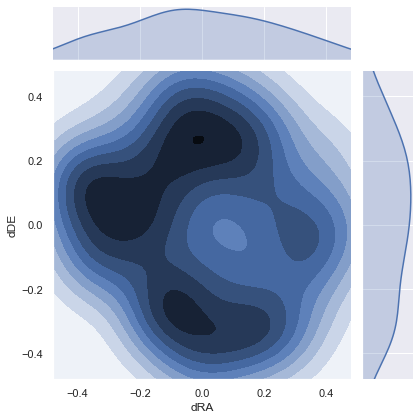

In [10]:
XLIM = [-max_angle_from_obj,max_angle_from_obj]
YLIM = [-max_angle_from_obj,max_angle_from_obj]

sns.jointplot(x='dRA',y='dDE', data=df.loc[:100], kind='kde', xlim=XLIM, ylim=YLIM) 

In [11]:
max_angle = 1.2*max_angle_from_obj

num_along_dim = 100
var1 = np.linspace(-max_angle, max_angle, num=num_along_dim)
var2 = np.linspace(-max_angle, max_angle, num=num_along_dim)

grid_var1, grid_var2 = np.meshgrid(var1, var2)
positions = np.vstack([grid_var1.flatten(), grid_var2.flatten()])
# print(positions)

def get_data(ii=0):
    bin_array = np.logical_and(time_mets>=time_bin_start_samp[ii], time_mets<=time_bin_end_samp[ii])
    if np.sum(bin_array) >= 3:
        data = df.loc[bin_array]
        x = data['dRA'].values
        y = data['dDE'].values
        return np.array([x,y]), 1
    else:
        return np.array([0,0]), 0

num_bins_analyze = num_samp_bins
photon_grid = np.zeros([num_bins_analyze, num_along_dim, num_along_dim])
for ii in range(0,num_bins_analyze):
    bin_photons, is_points = get_data(ii)
    if is_points == 1:
        num_photons = bin_photons.shape[1]
#         print(bin_photons)

        gkde = gaussian_kde(bin_photons, bw_method=0.3)
        pdf = gkde.evaluate(positions)
        photon_grid[ii] = num_photons*pdf.reshape([num_along_dim,num_along_dim])
    else:
        continue

all_photons = np.array([df['dRA'].values, df['dDE'].values])
# all_y = df['dDE'].values
num_photons = total_events
gkde = gaussian_kde(all_photons, bw_method=0.1)
pdf = gkde.evaluate(positions)
all_photon_grid = num_photons*pdf.reshape([num_along_dim,num_along_dim])

# print(photon_grid)
    
# num_points = get_data().shape[1]
# # print(get_data().T)
# gkde = gaussian_kde(get_data(), bw_method=0.3)

# pdf = gkde.evaluate(positions)
# # print(blah*num_points)


In [12]:
''' Finding power at 53-days '''

num_freq = 10
period = np.linspace(52, 54, num=num_freq)
freq = 1/period

power_array = np.zeros([num_along_dim, num_along_dim, num_freq])
for ii in range(0,num_along_dim):
    for jj in range(0,num_along_dim):
#         print(time_bin_samp_days.shape, photon_grid[:,ii,jj].shape)
#         blah = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii,jj]).power(freq)
        power_array[ii,jj] = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii,jj]).power(freq)

power_array = np.max(power_array,axis=-1)

exposure_power_array = LombScargle(time_bin_samp_days[:num_bins_analyze], exposure_bin_samp[:num_bins_analyze]).power(freq)
exposure_power = np.max(exposure_power_array)
print('Exposure Power array: '+str(exposure_power_array))

counts_power_array = LombScargle(time_bin_samp_days[:num_bins_analyze], counts_bin_samp[:num_bins_analyze]).power(freq)
counts_power = np.max(counts_power_array)
print('Counts Power array: '+str(counts_power_array))

Exposure Power array: [0.05090216 0.04397945 0.00529138 0.04073964 0.17994313 0.27415226
 0.20853527 0.07277561 0.01455691 0.03682108]
Counts Power array: [0.01766822 0.01156292 0.00198744 0.0016035  0.00511618 0.00757866
 0.0103211  0.00936012 0.00386662 0.00401902]


C:\Users\psyko\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


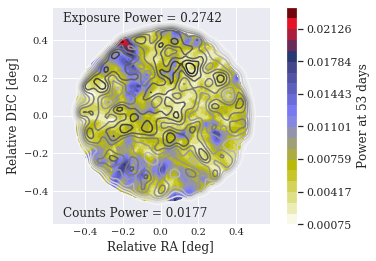

In [14]:
''' Plotting power '''
###
### PLOT
###
font = {'family' : 'serif',
		'weight' : 'normal',
		'size'   : 12}

matplotlib.rc('font', **font)

cmap2 = plt.get_cmap('gist_stern_r')
cmap  = plt.get_cmap('Greys')#'gnuplot2')#'BuPu_r')
fig = plt.figure()

gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0,0])

for axis in ['top','bottom','left','right']:
	ax0.spines[axis].set_linewidth(1)
ax0.tick_params(which='major',width=0.5, length=8, labelsize='small', direction='in')
ax0.tick_params(which='minor',width=0.25, length=5, direction='in')

grid_dist = (grid_var1**2 + grid_var2**2)**0.5
in_roi = grid_dist < bin_roi

max_power = np.max(power_array[in_roi])
min_power = np.min(power_array[in_roi])
LEVELS = np.linspace(min_power, max_power, num=21)

power_array_masked = np.ma.masked_where(in_roi == False, power_array)

CF1 = ax0.contourf(grid_var1, grid_var2, power_array_masked, cmap=cmap2, levels=LEVELS, zorder=9)
EXPO = ax0.contour(grid_var1, grid_var2, power_array_masked, colors='r', levels=[exposure_power], zorder=10)

cbar = fig.colorbar(CF1)
cbar.set_label('Power at 53 days')

C1 = ax0.contour(grid_var1, grid_var2, all_photon_grid, levels=10, cmap=cmap, zorder=9.5)

ax0.set_aspect('equal')
ax0.text(0.05, 0.95, 'Exposure Power = '+str(round(exposure_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)
ax0.text(0.05, 0.05, 'Counts Power = '+str(round(counts_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)

ax0.set_xlabel('Relative RA [deg]')
ax0.set_ylabel('Relative DEC [deg]')


plt.show()

plot_name = './map_photon_power_'+object+'_e'+str(ebin_number)+'_'
for n in range(0,100):
	if os.path.isfile(plot_name+str(n).zfill(2)+'.png'):
		continue
	else:
		plt.savefig(plot_name+str(n).zfill(2)+'.png', bbox_inches='tight', dpi=400)
		break
plt.close()


______________________________________________

Energy analysis